##Data Preparation
Install all libs for PDF extract, text preprocessing.

In [ ]:
import os
import zipfile
import random
import nltk
import spacy
from nltk.tokenize import RegexpTokenizer
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
!pip install pdfminer.six
from nltk.corpus import stopwords
import pickle
import pandas as pd


# Download necessary NLP resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
# Ensure stopwords are downloaded
nltk.download('stopwords')


The downloading from Scopus sometimes can be messy, some papers are half downloaded, some turn to be corroupted. This function will list all pdf path names failed to be processed by pdfplumber. You need to manually remove those pdf from your local data folder.

In [ ]:

import glob
!pip install pdfplumber
import pdfplumber

from tqdm import tqdm

def scan_pdf_quick_failures_with_progress(zip_path, extract_to="Data"):
    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    dataset_folder = os.path.join(extract_to, "Dataset_200")
    category_folders = [os.path.join(dataset_folder, cat) for cat in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, cat))]


    failed_pdfs = []
    total_pdfs_per_folder = {}

    pdf_files = []
    for category in category_folders:
        category_name = os.path.basename(category)
        category_pdfs = glob.glob(os.path.join(category, "*.pdf"))
        total_pdfs_per_folder[category_name] = len(category_pdfs)
        pdf_files.extend(category_pdfs)

    # Print total number of PDFs per folder
    print("\nTotal PDFs per folder:")
    for folder, count in total_pdfs_per_folder.items():
        print(f"{folder}: {count} PDFs")


    # Progress bar with tqdm
    for pdf in tqdm(pdf_files, desc="Scanning PDFs", unit="file"):
        try:
            with pdfplumber.open(pdf) as pdf_doc:
                metadata = pdf_doc.metadata  # Extract metadata
                num_pages = len(pdf_doc.pages)  # Get the number of pages

                # Failure conditions
                if num_pages == 0:  # Empty PDF
                    failed_pdfs.append(pdf)
                    continue

                first_page_text = pdf_doc.pages[0].extract_text() if num_pages > 0 else ""
                if not first_page_text or len(first_page_text.strip()) < 20:  # Text too short
                    failed_pdfs.append(pdf)
                    continue

                if metadata and metadata.get("Producer") is None:  # Corrupt or scanned PDF
                    failed_pdfs.append(pdf)
                    continue

        except Exception as e:
            print(f"Error scanning {pdf}: {e}")
            failed_pdfs.append(pdf)

    return failed_pdfs

# Example usage:
failed_files = scan_pdf_quick_failures_with_progress("/data/Dataset_200.zip")
print("Likely Failed PDFs:", failed_files)


   
This function extracts text from PDFs stored in a ZIP file.

    Args:
        zip_path (str): Path to the ZIP file.
        extract_to (str): Directory to extract the ZIP contents.

    Returns:
        list: Extracted text from PDFs.
        list: Corresponding category labels.

In [ ]:


def extract_text_from_pdfs(zip_path, extract_to="Data"):

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    dataset_folder = os.path.join(extract_to, "Dataset_200")
    category_folders = [os.path.join(dataset_folder, cat) for cat in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, cat))]

    documents = []
    labels = []

    for category in category_folders:
        category_name = os.path.basename(category)
        pdf_files = glob.glob(os.path.join(category, "*.pdf"))

        for pdf in pdf_files:
            try:
                with pdfplumber.open(pdf) as pdf_doc:
                    text = "\n".join([page.extract_text() for page in pdf_doc.pages if page.extract_text()])
                documents.append(text)
                labels.append(category_name)
            except Exception as e:
                print(f"Error extracting text from {pdf}: {e}")

    return documents, labels


Perform extract text from a zip file.

In [ ]:
zip_path = "/content/Dataset_200.zip"  # Replace with actual ZIP file path
documents, labels = extract_text_from_pdfs(zip_path)





Save the original Raw text documents, which later you can load it as a pickle file.

In [ ]:
# Save to a pickle file
with open("documents_labels.pkl", "wb") as f:
    pickle.dump((documents, labels), f)

print("Documents and labels saved to 'documents_labels.pkl'")



**Optional Step, run only when you already have exiting Pickle file*

In [11]:


#Load Pickle file
with open("documents_labels.pkl", "rb") as f:
    documents, labels = pickle.load(f)

print("Loaded documents and labels from 'documents_labels.pkl'")


Loaded documents and labels from 'documents_labels.pkl'


##Preprocessing

Tokenizes, removes special characters, removes stopwords, and lemmatizes document text.

    
    Args:
        documents (list of str): Raw text documents.
    
    Returns:
        list of list: Preprocessed tokenized documents.

In [6]:
# Tokenization and Preprocessing
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\b[a-zA-Z0-9]+\b')  # Keeps words and words containing numbers but removes special characters


def preprocess_documents(documents):

    lemmatized_docs = []

    for doc in documents:
        tokens = tokenizer.tokenize(doc.lower())  # Convert to lowercase and tokenize

        # Remove pure numeric tokens but keep words that contain numbers (e.g., "c9" is kept but "9" is removed)
        tokens = [t for t in tokens if not t.isnumeric()]

        # Remove single-character words
        tokens = [t for t in tokens if len(t) > 1]

        # Remove words containing 'cid' or 'cid_xxxxxxx' pattern, which are placeholder for a missing or unrecognized character in PDF text extraction.
        tokens = [t for t in tokens if not (t.startswith('cid') and (len(t) == 3 or t[3:].isdigit()))]

        # Remove stopwords
        tokens = [t for t in tokens if t not in stop_words]

        # Perform lemmatization
        lemmatized_tokens = [token.lemma_ for token in nlp(" ".join(tokens))]

        lemmatized_docs.append(lemmatized_tokens)

    return lemmatized_docs



Creates bigrams and trigrams for the documents.
    
    Args:
        docs (list of list): Tokenized and lemmatized documents.
        min_count (int): Minimum frequency for n-grams to be considered.
  
  Phrases(threshold): a PMI scoring cutoff used to decide whether two words should be combined into a phrase
    
    Returns:
        list of list: Tokenized documents with bigrams and trigrams.

In [7]:
# Function to add bigrams and trigrams
def generate_ngrams(docs, min_count=20):

    bigram = Phrases(docs, min_count=min_count, threshold=10)
    trigram = Phrases(bigram[docs], min_count=min_count, threshold=10)

    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)

    return [trigram_mod[bigram_mod[doc]] for doc in docs]

Removes tokens that are too rare or too common in the dataset.

Keepping duplicates inside individual documents is recommended for feature extraction methods like BOW, TF-IDF, LDA. But not recommended for Word Embeddings. So the answer is keepping dups.


Also removes duplicates within a document
    
    Args:
        docs (list of list): Tokenized documents.
        extreme_low (int): Minimum occurrence threshold.
        extreme_high (float): Maximum occurrence threshold (percentage of documents).
    
    Returns:
        list of list: Filtered tokenized documents.

In [8]:
def filter_tokens(docs, no_below=20, no_above=0.5):
    dictionary = Dictionary(docs)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    filtered_docs = [[token for token in doc if token in dictionary.token2id] for doc in docs]
    return filtered_docs


Perform Preprocessing

In [12]:
processed_docs = preprocess_documents(documents)
ngram_docs = generate_ngrams(processed_docs)
filtered_docs = filter_tokens(ngram_docs)


In [13]:
# Create dictionary and corpus
def create_corpus(docs):
    dictionary = Dictionary(docs)
    dictionary.filter_extremes(no_below=1, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary, corpus

In [14]:
# Create corpus using the filtered dictionary
dictionary, corpus = create_corpus(filtered_docs)  # Correct usage
print(f"Corpus size: {len(corpus)}")
print(f"create_corpus Type of dictionary: {type(dictionary)}")

Corpus size: 1000
create_corpus Type of dictionary: <class 'gensim.corpora.dictionary.Dictionary'>


In [15]:
# Generate 150-word random continuous records
def create_random_samples(docs, labels, word_count=150):

    samples = []

    # Extract a continuous section of 150 words per document
    for doc, label in zip(docs, labels):
        if len(doc) > word_count:
            start_idx = random.randint(0, len(doc) - word_count)
            sample_text = doc[start_idx:start_idx + word_count]
        else:
            sample_text = doc  # If document is too short, keep as is

        samples.append((" ".join(sample_text), label))

    # Shuffle the dataset while maintaining label associations
    random.shuffle(samples)

    return samples

In [16]:
samples = create_random_samples(filtered_docs, labels)

# Output results
print(f"Extracted {len(documents)} documents with labels.")
print(f"Sample processed text: {samples[0] if samples else 'No samples'}")

Extracted 1000 documents with labels.
Sample processed text: ('transition pair transition object complexity alert history tuple transition history history complexity log interface scalability requirement record rather list significantly_increase record d3 js graph chart interface graphs chart dom d3 js degrade significantly volume stress testing large_number employee program run memory ren der graphs chart back end browser interaction would disabled chart static image insider_threat_detection topic insider_threat attract interested commu whereas anomaly_detection organisation attempt mitigate_risk insider_threat security_policy rule_base monitor violation policy pro_pose complement aforementione devel basedsystem anomaly_detection ten synthetic pat tern able_detect perpetrator seven false_positive alert sys complexity depend linearly memory complexity depend linearly product employee real_time alert situational_awareness move forward intend perfor organisation appendix every detection_

Save preprocessed ransomized data, which later you can load it as a pickle file.

In [ ]:


# File paths to save the preprocessed samples
pkl_file = "preprocessed_samples.pkl"
csv_file = "preprocessed_samples.csv"

# Save samples as a Pickle file
with open(pkl_file, "wb") as f:
    pickle.dump(samples, f)

# Save samples as a CSV file
df = pd.DataFrame(samples, columns=["Text", "Label"])
df.to_csv(csv_file, index=False)

print(f"Saved preprocessed samples to {pkl_file} and {csv_file}")



**Optional Step, run only when you already have exiting Pickle file*

In [ ]:
# Function to load Pickle file
def load_samples_from_pkl(pkl_path):
    with open(pkl_path, "rb") as f:
        return pickle.load(f)

# Function to load CSV file
def load_samples_from_csv(csv_path):
    return pd.read_csv(csv_path)

# Example usage
loaded_samples_pkl = load_samples_from_pkl(pkl_file)
loaded_samples_csv = load_samples_from_csv(csv_file)

print(f"Loaded {len(loaded_samples_pkl)} samples from Pickle.")
print(f"Loaded {len(loaded_samples_csv)} samples from CSV.")

#Feature Extraction


Install all libs for feature extraction and evaluation.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
from gensim.models import Word2Vec
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from gensim.models import LdaModel
from sklearn.metrics import confusion_matrix
from statsmodels.stats.inter_rater import fleiss_kappa
import seaborn as sns


#BOW

Creates a dictionary and Bag-of-Words corpus representation of the documents.
    
    Args:
        docs (list of list): Tokenized and filtered documents.
    
    Returns:
        tuple: Dictionary object and corresponding corpus.

In [20]:
# Feature extraction functions
def get_bow(texts):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(texts), vectorizer


#LDA

Train an LDA model using Gensim.

In [21]:

# LDA Feature Extraction (Use precomputed dictionary and corpus)
def get_lda(dictionary, corpus, num_topics=10):

    #print(f"get_lda Type of dictionary: {type(dictionary)}")
    if not isinstance(dictionary, Dictionary):
        raise TypeError(f"Expected gensim.corpora.Dictionary, got {type(dictionary)} instead.")

    if not isinstance(corpus, list):
        raise TypeError(f"Expected list for corpus, got {type(corpus)} instead.")

    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

    # Ensure all documents have a fixed-size feature representation
    lda_features = np.zeros((len(corpus), num_topics))
    for i, doc in enumerate(corpus):
        topic_distribution = lda.get_document_topics(doc, minimum_probability=0)
        for topic_id, prob in topic_distribution:
            lda_features[i, topic_id] = prob  # Assign probability to topic index

    return lda_features, lda


###Compute coherence score for LDA model using top topics.
####>Separate evaluation rubric from other methods.

**LDA is a topic modeling algorithm, meaning it assigns words to topics rather than clustering entire documents. Standard clustering evaluation metrics (e.g., Silhouette Score, Homogeneity Score) require explicit document labels or distance-based clusters, which LDA does not produce. Instead, Coherence Score evaluates the semantic similarity of words within topics, making it the best-suited metric for LDA evaluation.*

In [99]:
# Compute Coherence Score for LDA

def compute_coherence(model, dictionary, texts, num_topics=10, num_words=20):

    topics = model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    topic_word_list = [[word for word, _ in topic_words] for _, topic_words in topics]

    coherence_model = CoherenceModel(topics=topic_word_list, texts=texts, dictionary=dictionary, coherence='c_v')
    avg_topic_coherence = coherence_model.get_coherence()

    print(f'Average topic coherence for LDA: {avg_topic_coherence:.4f}')
    return avg_topic_coherence


#TF-IDF

In [23]:
def get_tfidf(texts):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(texts), vectorizer

#Word Embedding

In [100]:
def get_word_embeddings(texts, vector_size=100, window=5, min_count=2):
    tokenized_texts = [text.split() for text in texts]
    model = Word2Vec(sentences=tokenized_texts, vector_size=vector_size, window=window, min_count=min_count, workers=4)

    # Ensure all documents have a fixed-size vector
    embeddings = np.zeros((len(tokenized_texts), vector_size))

    for i, words in enumerate(tokenized_texts):
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:
            embeddings[i] = np.mean(word_vectors, axis=0)  # Compute mean vector

    return embeddings, model


###Computes the average cosine similarity among word embeddings.
####>Separate evaluation rubric from other methods.


    Args:
        embeddings (numpy.ndarray): Array of word embeddings.

    Returns:
        float: Average cosine similarity score.

In [101]:
# Compute Word Embedding Evaluation using Cosine Similarity
def compute_word_embedding_similarity(embeddings):
    if len(embeddings) > 1:
        similarity_matrix = cosine_similarity(embeddings)
        np.fill_diagonal(similarity_matrix, 0)  # Ignore self-similarity
        Average_cosine_similarity=np.mean(similarity_matrix)
        print(f'Average cosine similarity for Word2Vec: {Average_cosine_similarity:.4f}')
        return Average_cosine_similarity
    return None


#Visualization

Create a separate folder to store all scatter plots.

In [26]:
# Save visualization
visualization_dir = "visualizations"
os.makedirs(visualization_dir, exist_ok=True)

#Dimensionality reduction
for 2D visuliztion of features

In [27]:
# Dimensionality reduction using PCA
def apply_pca(features, variance_retained=0.95):
    pca = PCA(n_components=variance_retained)
    reduced_features = pca.fit_transform(features.toarray() if hasattr(features, 'toarray') else features)
    return reduced_features, pca



Determine optimal clusters using the Elbow Method.


In [28]:

def elbow_plot(features, feat_name, visualization_dir, max_clusters=10):
    distortions = []
    k_range = range(1, max_clusters + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        distortions.append(kmeans.inertia_)

    # Plot elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, distortions, marker='o', linestyle='-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion (Inertia)')
    plt.title(f'Elbow Method for KMeans - {feat_name}')
    plt.savefig(os.path.join(visualization_dir, f'elbow_{feat_name}_KMeans.png'))
    plt.close()


Determine optimal clusters using the AIC & BIC plot.

In [29]:
def plot_bic_aic(features, n_components, feat_name, visualization_dir):

    models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(features) for n in n_components]

    bic_values = [m.bic(features) for m in models]
    aic_values = [m.aic(features) for m in models]

    # Find optimal K based on the lowest BIC and AIC values
    optimal_k_bic = n_components[np.argmin(bic_values)]
    optimal_k_aic = n_components[np.argmin(aic_values)]

    plt.figure(figsize=(8, 5))
    plt.plot(n_components, bic_values, marker='o', linestyle='-', label='BIC')
    plt.plot(n_components, aic_values, marker='s', linestyle='-', label='AIC')

    # Mark the optimal points
    plt.axvline(optimal_k_bic, color='blue', linestyle='--', alpha=0.7, label=f'Optimal K (BIC): {optimal_k_bic}')
    plt.axvline(optimal_k_aic, color='red', linestyle='--', alpha=0.7, label=f'Optimal K (AIC): {optimal_k_aic}')

    plt.xlabel("Number of Components")
    plt.ylabel("Score")
    plt.legend()
    plt.title(f"{feat_name} - EM BIC/AIC Scores")
    plt.savefig(os.path.join(visualization_dir, f"bic_aic_{feat_name}_EM.png"))
    plt.close()


#Evaluation

In [30]:
# Extract text and labels from preprocessed data
texts, true_labels = zip(*samples)  # Unzip into separate lists


Align clustering labels with true labels using the Hungarian algorithm.
    

    true_labels contains string labels, while cluster_labels contains numeric labels (e.g., 0, 1, 2, ... from clustering algorithms).

    Before computing confusion_matrix, convert true_labels to numeric labels using LabelEncoder



In [31]:
from scipy.optimize import linear_sum_assignment

def align_labels(true_labels, cluster_labels,filename):

    # Convert true_labels to numeric format if they are strings
    if isinstance(true_labels[0], str):
        label_encoder = LabelEncoder()
        true_labels = label_encoder.fit_transform(true_labels)

    # Compute confusion matrix
    contingency_matrix = confusion_matrix(true_labels, cluster_labels)

    # Perform label alignment using Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)  # Maximize agreement
    mapping = dict(zip(col_ind, row_ind))

    # Generate aligned labels
    aligned_labels = np.vectorize(lambda label: mapping.get(label, label))(cluster_labels)

    # Create and save confusion matrix visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {filename}")

    # Save the plot
    os.makedirs(visualization_dir, exist_ok=True)
    plt.savefig(os.path.join(visualization_dir, filename))
    plt.close()

    return aligned_labels



###Fleiss' Kappa
    
    Args:
        cluster_labels_list (list of lists): Cluster assignments from different models.
        num_categories (int): Expected number of clusters.

    Returns:
        float or None: Fleiss' Kappa score, or None if K normalization fails.


In [102]:
def compute_fleiss_kappa(cluster_labels_list, num_categories):

    cluster_matrix = np.array(cluster_labels_list).T  # Transpose for Fleiss' Kappa
    doc_label_counts = np.zeros((len(cluster_matrix), num_categories))

    for i, doc in enumerate(cluster_matrix):
        for label in doc:
            doc_label_counts[i, label] += 1  # Count occurrences

    return fleiss_kappa(doc_label_counts)


Performs clustering and calculates evaluation metrics.

    Args:
        features (array-like): Feature representation of the documents.
        true_labels (array-like): Ground truth labels.
        cluster_method (str): The clustering algorithm to use ('kmeans', 'em', or 'agglo').
        optimal_k (int, optional): The optimal number of clusters, if applicable.

    Returns:
        dict: A dictionary of evaluation metrics.

In [33]:
def cluster_and_evaluate(features, true_labels, cluster_method, optimal_k=None):

    if optimal_k:
        cluster_methods['KMeans'].set_params(n_clusters=optimal_k)
        cluster_methods['EM'].set_params(n_components=optimal_k)
        cluster_methods['Agglo'].set_params(n_clusters=optimal_k)

    if cluster_method not in cluster_methods:
        raise ValueError(f"Unsupported clustering method: {cluster_method}")

    model = cluster_methods[cluster_method]
    cluster_labels = model.fit_predict(features)

    metrics = {
        "Silhouette Score": silhouette_score(features, cluster_labels) if len(features) > 1 else None,
        "Homogeneity Score": homogeneity_score(true_labels, cluster_labels),
        "Completeness Score": completeness_score(true_labels, cluster_labels),
        "V-measure Score": v_measure_score(true_labels, cluster_labels),
        "Adjusted Rand Score": adjusted_rand_score(true_labels, cluster_labels),
        "Adjusted Mutual Info Score": adjusted_mutual_info_score(true_labels, cluster_labels),
    }
    return metrics, cluster_labels

##Running feature extraction and clustering

In [103]:

##To save evaluation results
results = {}

#For Kappa unalignment labels
kappa_labels_list = {}

#For label alignments
cluster_labels_list = {}

# Set optimal_k to the number of unique true labels
num_categories = len(set(true_labels))

feature_extractors = {
    "BOW": get_bow,
    "TF-IDF": get_tfidf,
    "LDA": get_lda,
    "Word2Vec": get_word_embeddings
}

# Define clustering methods globally
cluster_methods = {
    'KMeans': KMeans(n_clusters=num_categories, random_state=42),
    'EM': GaussianMixture(n_components=num_categories, random_state=42),
    'Agglo': AgglomerativeClustering(n_clusters=num_categories)
}


LDA already reduces dimensionality by representing each document as a probability distribution over topics (e.g., 10 topics instead of 50,000 words).
PCA is not necessary for LDA because LDA directly generates a lower-dimensional topic space.

MAP will further reduce LDA’s topic space to 2D for visualization.

In [ ]:
! pip install umap-learn
import umap

A complex For loop to go through each feature and clustering method while saving evalution results and plots at the same time.



*   BOW & TF-IDF → Use clustering metrics (Silhouette Score, Homogenity_Score, Completenss_Score,V_measure_Score,Adjusted_Rand_Score,Adjusted_Mutual_Info_Score).
*   Word Embeddings → Use intrinsic evaluation (cosine similarity, word analogy ).
*   LDA → Coherence Score(PMI)



**Mark*
*   PCA in only applied to features > 300+ dimensions ("BOW", "TF-IDF")
*   All features are applied UMAP.







In [ ]:


for feat_name, feat_extractor in feature_extractors.items():
    print(f"Processing {feat_name}...")

    # Check if LDA requires an additional argument
    if feat_name == "LDA":
        #print(f"For loop Type of dictionary: {type(dictionary)}")
        features, model = feat_extractor(dictionary, corpus)  # Pass dictionary explicitly
        print(f"LDA topic distribution shape: {features.shape}")

    else:
        features, model = feat_extractor(texts)
        print(f"Other Feature matrix shape: {feat_name}: {features.shape}")

    if feat_name in ["BOW", "TF-IDF"]:
        features, pca = apply_pca(features)
        print(f"PCA-reduced features shape: {feat_name}: {features.shape}")

    if feat_name == "LDA":
        coherence = compute_coherence(model, dictionary, filtered_docs)
    else:
        coherence = None

    if feat_name == "Word2Vec":
        word_embedding_similarity = compute_word_embedding_similarity(features)
    else:
        word_embedding_similarity = None



    # Apply UMAP after PCA to visualize in 2D
    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_features = reducer.fit_transform(features)

    # Debugging: Check the shape of umap_features
    print(f"UMAP output shape: {feat_name}: {umap_features.shape}")  # Expecting (num_samples, 2)

    ######
    kappa_labels_list[feat_name] = {}

    for clustering_method in cluster_methods.keys():
        print(f"  Clustering with {clustering_method} (K={num_categories})...")
        #Intendedly pass num_categories=5 into cluster_and_evaluate since we already know the optimal K should be true label count.
        metrics, cluster_labels = cluster_and_evaluate(umap_features, true_labels, clustering_method, num_categories)

        # Set filename dynamically for each clustering method
        confusion_matrix_filename = f"confusion_matrix_{feat_name}_{clustering_method}.png"

        #Fleiss' Kappa should not use aligned_labels
        kappa_labels_list[feat_name][clustering_method] = cluster_labels  # Store raw labels, not aligned labels

        #for external metrics which requires true label alignments
        aligned_labels = align_labels(true_labels, cluster_labels, filename=confusion_matrix_filename)


        if clustering_method not in cluster_labels_list:
            cluster_labels_list[clustering_method] = []
        cluster_labels_list[clustering_method].append(aligned_labels)

        '''
        if feat_name == "LDA":
            metrics["Coherence Score"] = coherence
        if feat_name == "Word2Vec":
            metrics["Word Embedding Similarity"] = word_embedding_similarity
        '''

        results[(feat_name, clustering_method)] = metrics

        # Visualization for each clustering method
        visualization_filename = f"{feat_name}_{clustering_method}_visualization.png"
        if clustering_method == "KMeans":
            kmeans = cluster_methods[clustering_method].fit(umap_features)
            plt.figure(figsize=(10, 6))
            plt.scatter(umap_features[:, 0], umap_features[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
            plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, edgecolors='black', label="Centroids")
            plt.legend()
            plt.title(f"{feat_name} - {clustering_method} (UMAP)")
            plt.savefig(os.path.join(visualization_dir, visualization_filename))
            plt.close()

            # Elbow Method for KMeans
            elbow_filename = f"elbow_{feat_name}_KMeans.png"
            elbow_plot(features, feat_name, visualization_dir, max_clusters=10)


        elif clustering_method == "EM":
            gmm = cluster_methods[clustering_method].fit(umap_features)
            labels = gmm.predict(umap_features)
            plt.figure(figsize=(10, 6))
            plt.scatter(umap_features[:, 0], umap_features[:, 1], c=labels, cmap='viridis', alpha=0.6)
            plt.title(f"{feat_name} - {clustering_method} (UMAP)")
            plt.savefig(os.path.join(visualization_dir, visualization_filename))
            plt.close()


            # BIC & AIC plots for EM
            EM_components = range(1, 11)
            plot_bic_aic(umap_features,EM_components, feat_name, visualization_dir)


        elif clustering_method == "Agglo":
            plt.figure(figsize=(10, 6))
            plt.scatter(umap_features[:, 0], umap_features[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
            plt.title(f"{feat_name} - {clustering_method} (UMAP)")
            plt.savefig(os.path.join(visualization_dir, visualization_filename))
            plt.close()

            # Dendrogram for Agglomerative Clustering
            from scipy.cluster.hierarchy import dendrogram, linkage
            plt.figure(figsize=(10, 6))
            linkage_matrix = linkage(umap_features, method='ward')
            dendrogram(linkage_matrix)
            plt.title(f"{feat_name} - Agglomerative Dendrogram")
            plt.savefig(os.path.join(visualization_dir, f"dendrogram_{feat_name}_Agglo.png"))
            plt.close()






Save plots to 'visualizations' folder and zip them for easy download.

In [91]:
import shutil

# Define the folder to zip and output zip file name
folder_path = "/content/visualizations"
zip_output_path = "/content/visualizations.zip"

# Create a zip file
shutil.make_archive(zip_output_path.replace('.zip', ''), 'zip', folder_path)

print(f"Folder '{folder_path}' has been zipped as '{zip_output_path}'")

Folder '/content/visualizations' has been zipped as '/content/visualizations.zip'


In [105]:
# Save results for later visualization
with open("clustering_results.pkl", "wb") as f:
    pickle.dump(results, f)

df_results = pd.DataFrame(results).T
df_results.to_csv("clustering_results.csv")


  Identify characteristics of misclassified instances using frequent words and collocations.
  
    
    Args:
        texts (list of str): List of document texts.
        cluster_labels (list): Cluster assignments.
        true_labels (list): Ground truth labels.
        num_top_words (int): Number of top frequent words/ngrams to extract.

    Returns:
        dict: Dictionary containing top words, bigrams, and trigrams.

In [106]:
from collections import Counter
from nltk import ngrams

def perform_error_analysis(texts, cluster_labels, true_labels, num_top_words=10):

    # Find misclassified instances
    misclassified_indices = [i for i, (cl, tl) in enumerate(zip(cluster_labels, true_labels)) if cl != tl]
    misclassified_texts = [texts[i] for i in misclassified_indices]

    # Tokenize words
    all_words = [word for text in misclassified_texts for word in text.split()]
    word_counts = Counter(all_words)

    # Get top frequent words
    top_words = word_counts.most_common(num_top_words)

    # Extract bigrams and trigrams
    bigrams = list(ngrams(all_words, 2))
    trigrams = list(ngrams(all_words, 3))
    bigram_counts = Counter(bigrams).most_common(num_top_words)
    trigram_counts = Counter(trigrams).most_common(num_top_words)

    # Save results to a DataFrame
    df_results = pd.DataFrame({
        "Top Words": [word for word, _ in top_words],
        "Top Word Counts": [count for _, count in top_words],
        "Top Bigrams": [" ".join(bg) for bg, _ in bigram_counts],
        "Bigram Counts": [count for _, count in bigram_counts],
        "Top Trigrams": [" ".join(tg) for tg, _ in trigram_counts],
        "Trigram Counts": [count for _, count in trigram_counts],
    })

    df_results.to_csv("error_analysis_results.csv", index=False)
    print("Error analysis results saved to 'error_analysis_results.csv'")

    return {
        "top_words": top_words,
        "bigrams": bigram_counts,
        "trigrams": trigram_counts
    }


Store Fleiss' Kappa scores separately

Compare multiple unaligned clustering methods (e.g., KMeans vs. EM vs. Agglo) as "raters" to assess their consistency (not accuracy).

Ignore true labels and focusing purely on agreement between methods.

In [107]:
fleiss_kappa_scores = {}
for feat_name, labels_dict in kappa_labels_list.items():
    if isinstance(labels_dict, dict):
        labels_list = [labels_dict[method] for method in cluster_methods.keys() if method in labels_dict]  # ✅ Extract clustering method labels

        if len(labels_list) > 1:  # Kappa needs multiple methods to compare
            fleiss_kappa_score = compute_fleiss_kappa(labels_list, num_categories)
            fleiss_kappa_scores[feat_name] = fleiss_kappa_score
            print(f"Fleiss' Kappa for {feat_name}: {fleiss_kappa_score:.4f}")
        else:
            print(f"Skipping Fleiss' Kappa for {feat_name}: Only one clustering method present.")


Fleiss' Kappa for BOW: 0.1391
Fleiss' Kappa for TF-IDF: 0.2799
Fleiss' Kappa for LDA: 0.3678
Fleiss' Kappa for Word2Vec: 0.3832


Store error analysis separately

In [108]:

# Store error analysis separately
error_analysis_results = {}
for clustering_method, labels_list in cluster_labels_list.items():
    error_analysis_results[clustering_method] = perform_error_analysis(texts, labels_list[-1], true_labels)



Error analysis results saved to 'error_analysis_results.csv'
Error analysis results saved to 'error_analysis_results.csv'
Error analysis results saved to 'error_analysis_results.csv'


  Visualizes error analysis results using bar charts and wordcloud.


In [109]:

from wordcloud import WordCloud

def visualize_error_analysis(error_analysis_results):

    top_words, bigrams, trigrams = error_analysis_results["top_words"], error_analysis_results["bigrams"], error_analysis_results["trigrams"]

    # Convert to lists for plotting
    words, word_counts = zip(*top_words)
    bigram_texts, bigram_counts = zip(*[(" ".join(bg), count) for bg, count in bigrams])
    trigram_texts, trigram_counts = zip(*[(" ".join(tg), count) for tg, count in trigrams])

    # Define a rainbow warm color palette
    rainbow_colors = sns.color_palette("Set2")

    # Plot frequent words
    plt.figure(figsize=(12, 5))
    plt.barh(words, word_counts, color=rainbow_colors[0])  # Use rainbow colors
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.title("Top Frequent Words in Misclassified Instances")
    plt.gca().invert_yaxis()
    plt.show()

    # Plot bigrams
    plt.figure(figsize=(12, 5))
    plt.barh(bigram_texts, bigram_counts, color=rainbow_colors[1])
    plt.xlabel("Frequency")
    plt.ylabel("Bigrams")
    plt.title("Top Bigram Collocations")
    plt.gca().invert_yaxis()
    plt.show()

    # Plot trigrams
    plt.figure(figsize=(12, 5))
    plt.barh(trigram_texts, trigram_counts, color=rainbow_colors[2])
    plt.xlabel("Frequency")
    plt.ylabel("Trigrams")
    plt.title("Top Trigram Collocations")
    plt.gca().invert_yaxis()
    plt.show()

    # Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Top Misclassified Words")
    plt.show()



Run error Analysis.

Error analysis results saved to 'error_analysis_results.csv'


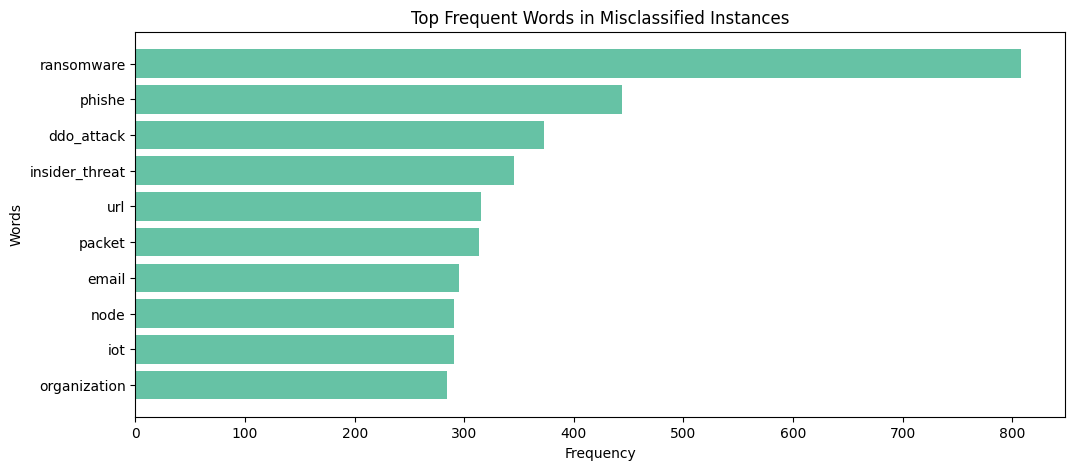

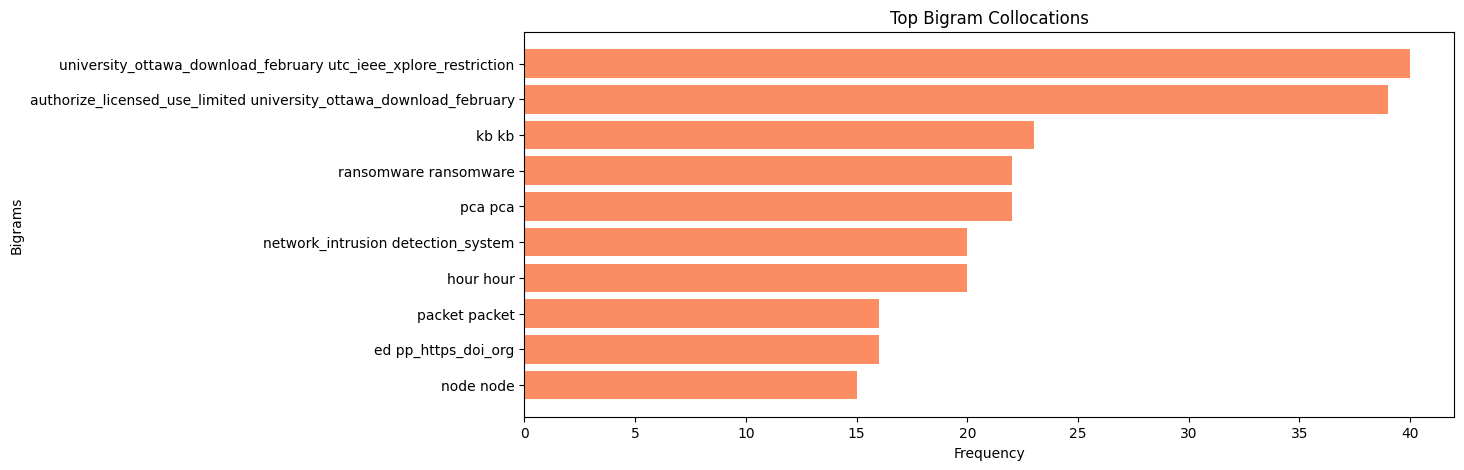

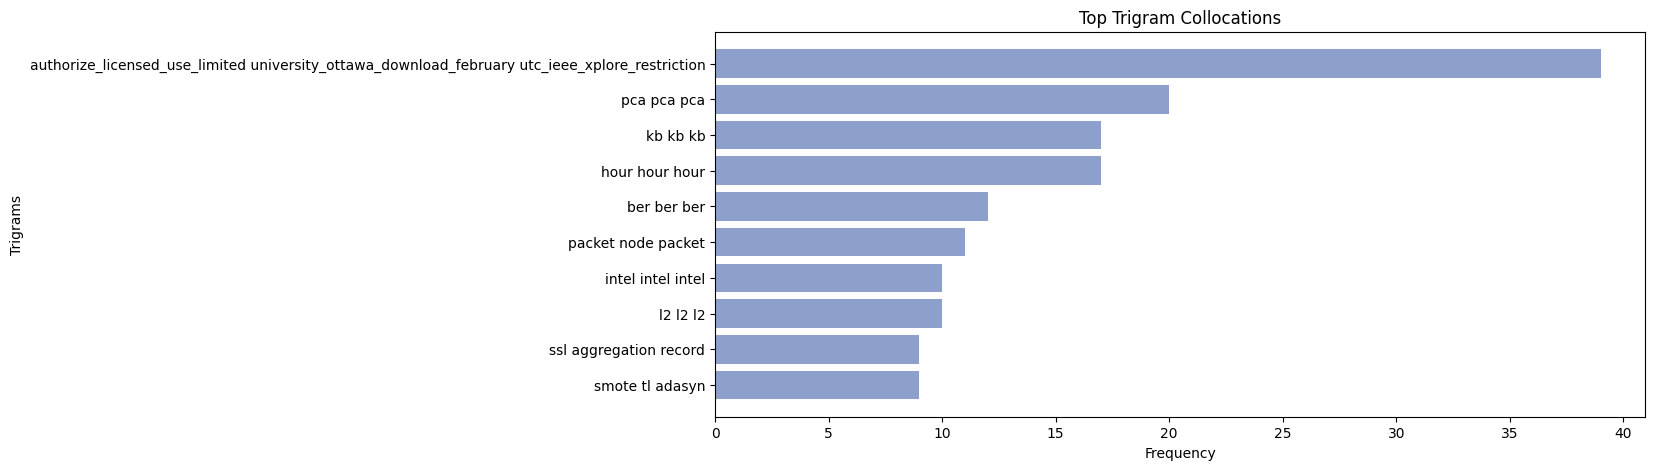

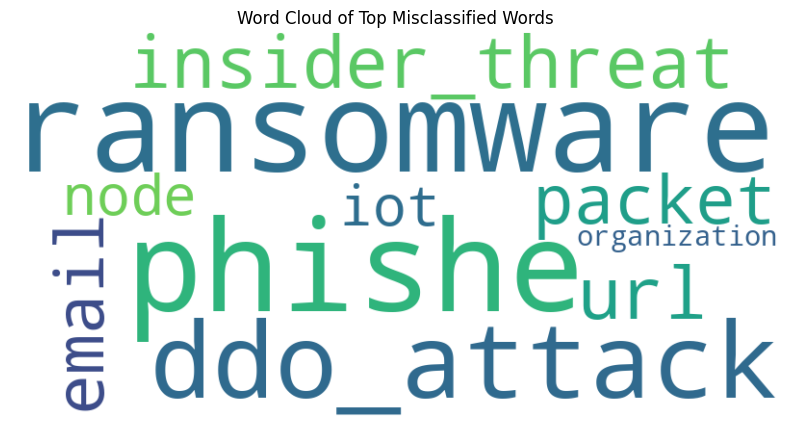

In [110]:
error_results = perform_error_analysis(texts, cluster_labels, true_labels)
visualize_error_analysis(error_results)

**Optional* heatmap to visulize all evaluation results.

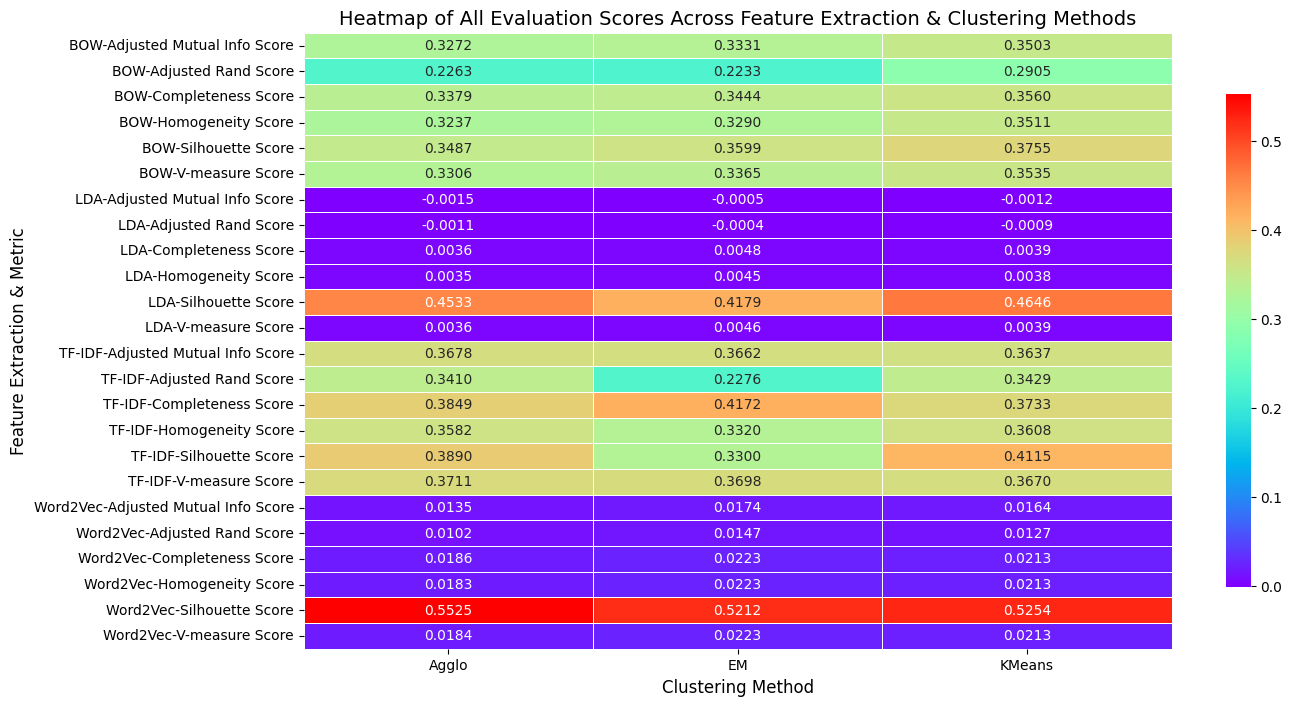

In [113]:


# Load the clustering results file
file_path = "clustering_results.csv"  # Ensure correct path if running locally
df_results = pd.read_csv(file_path)

# Rename first two columns to "Feature Extraction" and "Clustering Method"
df_results.rename(columns={"Unnamed: 0": "Feature Extraction", "Unnamed: 1": "Clustering Method"}, inplace=True)

# Convert numeric columns to float
metric_columns = df_results.columns[2:]  # Exclude categorical columns
df_results[metric_columns] = df_results[metric_columns].apply(pd.to_numeric, errors='coerce')

# Melt DataFrame for heatmap visualization
df_melted = df_results.melt(id_vars=["Feature Extraction", "Clustering Method"],
                            var_name="Metric", value_name="Score")

# Pivot table for heatmap: Feature Extraction vs Clustering Method with all evaluation scores
heatmap_data = df_melted.pivot_table(index=["Feature Extraction", "Metric"],
                                     columns="Clustering Method",
                                     values="Score")

# Generate a heatmap with a soft and user-friendly rainbow color scheme
plt.figure(figsize=(14, 8))

# Use a soft rainbow colormap
sns.heatmap(heatmap_data, annot=True, cmap="rainbow", fmt=".4f", linewidths=0.5, cbar_kws={'shrink': 0.8})

# Set title and labels
plt.title("Heatmap of All Evaluation Scores Across Feature Extraction & Clustering Methods", fontsize=14)
plt.xlabel("Clustering Method", fontsize=12)
plt.ylabel("Feature Extraction & Metric", fontsize=12)

# Show the heatmap
plt.show()


FacetGrid of bar plots for all evualtion scores.

In [ ]:


# Create a FacetGrid with a rainbow warm color palette and a legend for clustering methods
g = sns.FacetGrid(df_melted, col="Metric", col_wrap=3, height=4, sharey=False)

# Use a warm rainbow-like color palette for better differentiation
g.map_dataframe(sns.barplot, x="Feature Extraction", y="Score", hue="Clustering Method", palette="rainbow")

# Rotate x-axis labels for better readability and ensure all subplots have feature names
for ax in g.axes.flat:
    ax.set_xticklabels(df_melted["Feature Extraction"].unique(), rotation=45)  # Ensure correct feature names

# Add a legend outside the plot
g.add_legend(title="Clustering Method", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the title for the FacetGrid
g.fig.suptitle("Evaluation Scores Across Feature Extraction & Clustering Methods", fontsize=14)

# Adjust layout and show the plots
plt.subplots_adjust(top=0.9)
plt.show()


